In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from numpy.random import seed
seed(1)

In [3]:
data = pd.read_csv("../Resources/Prod_Forecast.csv", parse_dates=['Date'], index_col='Date', dayfirst=True)
data.head()

,Well,Well_Type,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
Date,,,,,,,,
2015-01-10,Well 10,Pre-perf,192.00,51.00,38.00,63.00,235.00,2.00
2015-01-11,Well 10,Pre-perf,308.00,43.00,31.00,67.00,235.00,37.00
2015-01-12,Well 10,Pre-perf,308.00,41.00,31.00,67.00,239.00,59.00
2015-01-13,Well 10,Pre-perf,309.09,40.53,29.90,67.04,238.86,59.69
2015-01-14,Well 10,Pre-perf,308.18,40.46,29.84,67.06,236.16,56.57


In [4]:
data = data[data.Well == "Well 15"]

In [5]:
data.head()

,Well,Well_Type,WaterRate,CasingHeadPressure,TubingHeadPressure,PumpSpeed,Torque,GasRate
Date,,,,,,,,
2014-09-30,Well 15,Pre-perf,0.0,364.0,336.0,100.0,98.0,0.0
2014-10-01,Well 15,Pre-perf,336.0,364.0,336.0,70.0,257.0,24.0
2014-10-02,Well 15,Pre-perf,388.0,31.0,3.0,85.0,257.0,38.0
2014-10-03,Well 15,Pre-perf,363.0,55.0,56.0,99.0,257.0,55.0
2014-10-04,Well 15,Pre-perf,646.0,56.0,56.0,178.0,258.0,54.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1220 entries, 2014-09-30 to 2018-12-30
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Well                1220 non-null   object 
 1   Well_Type           1220 non-null   object 
 2   WaterRate           1220 non-null   float64
 3   CasingHeadPressure  1220 non-null   float64
 4   TubingHeadPressure  1220 non-null   float64
 5   PumpSpeed           1220 non-null   float64
 6   Torque              1220 non-null   float64
 7   GasRate             1220 non-null   float64
dtypes: float64(6), object(2)
memory usage: 85.8+ KB


In [7]:
df =data.iloc[:,7:]


In [8]:
len(df)

1220

In [9]:
df

,GasRate
Date,
2014-09-30,0.00
2014-10-01,24.00
2014-10-02,38.00
2014-10-03,55.00
2014-10-04,54.00
...,...
2018-12-26,1557.62
2018-12-27,1523.56
2018-12-28,1536.20


<AxesSubplot:xlabel='Date'>

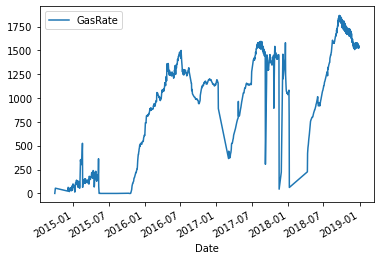

In [10]:
df.plot()

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

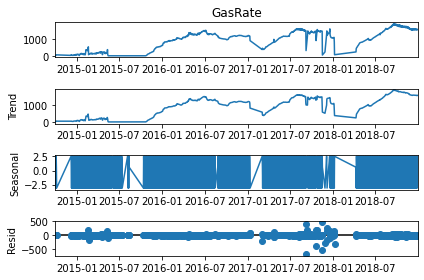

In [12]:
results = seasonal_decompose(df['GasRate'], period = 3)
results.plot();

In [13]:

## train_test_split 
# note that we don't split randomly 
len(df)

1220

In [14]:
length_data = 30
train_data = df[: len(df)-length_data]
test_data = df[-length_data:]

In [15]:
len(train_data)

1190

In [16]:

len(test_data)

30

In [17]:
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
train_scaled_data = scaler.transform(train_data)
test_scaled_data = scaler.transform(test_data)

In [18]:
# create the time series generator 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
batch_size = 1
length=12
generator = TimeseriesGenerator(train_scaled_data, train_scaled_data, length=length, batch_size=batch_size)

In [20]:
x,y = generator[0]

In [21]:
print(f'Given the Array: \n{x.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.01284838 0.02034327 0.0294442  0.02890885 0.02890885
 0.01286979 0.03426234 0.03345397 0.01713117 0.01766652 0.01657441]
Predict this y: 
 [[0.01468463]]


In [22]:
y

array([[0.01468463]])

In [23]:
x

array([[[0.        ],
        [0.01284838],
        [0.02034327],
        [0.0294442 ],
        [0.02890885],
        [0.02890885],
        [0.01286979],
        [0.03426234],
        [0.03345397],
        [0.01713117],
        [0.01766652],
        [0.01657441]]])

## create model

In [24]:
num_features = 1 
length= 12
model = Sequential()
model.add(LSTM(200, activation = 'relu', input_shape = (length, num_features))) # 200 neurons
model.add(Dense(1)) # we need to predict only the next value 

model.compile(optimizer='adam', loss='mse') # mse for continuous data 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [25]:
# create an earlystop and validation generator to start training
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)
val_generator = TimeseriesGenerator(test_scaled_data, test_scaled_data, length=length, batch_size=batch_size)

In [26]:
model.fit_generator(generator, epochs=10, validation_data = val_generator, callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1178/1178 [==============================] - 4s 4ms/step - loss: 0.0066 - val_loss: 0.0433
Epoch 2/10
1178/1178 [==============================] - 4s 3ms/step - loss: 0.0037 - val_loss: 0.0139
Epoch 3/10
1178/1178 [==============================] - 4s 3ms/step - loss: 0.0031 - val_loss: 2.5690e-04
Epoch 4/10
1178/1178 [==============================] - 4s 3ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 5/10
1178/1178 [==============================] - 4s 3ms/step - loss: 0.0026 - val_loss: 2.0242e-04
Epoch 6/10
1178/1178 [==============================] - 4s 3ms/step - loss: 0.0026 - val_loss: 5.2223e-04
Epoch 7/10
1178/1178 [==============================] - 4s 3ms/step - loss: 0.0024 - val_loss: 2.7575e-04
Epoch 8/10
1178/1178 [==============================] - 4s 3ms/step - loss: 0.0023 - val_loss: 2.0399e-04


In [27]:
loss = pd.DataFrame(model.history.history)

In [28]:
loss.head()

,loss,val_loss
0,0.006639,0.043349
1,0.003659,0.013941
2,0.003076,0.000257
3,0.002781,0.001637
4,0.002595,0.000202


<AxesSubplot:>

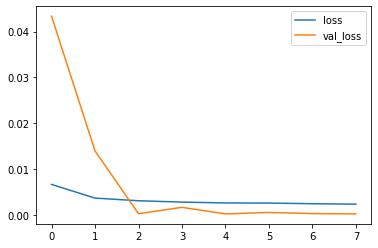

In [29]:
loss.plot()

# Model evaluation

In [30]:
# Forecast using the last 29 days from the dataset
predictions = []

first_eval_batch = train_scaled_data[-length:]
current_batch = first_eval_batch.reshape((1, length, num_features))

for i in range(len(test_data)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
predictions_inverse_scaled = scaler.inverse_transform(predictions)
test_data['predictions'] = predictions_inverse_scaled

C:\Users\19810\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
test_data

,GasRate,predictions
Date,,
2018-12-01,1533.14,1569.300243
2018-12-02,1574.72,1570.474190
2018-12-03,1561.86,1568.799334
2018-12-04,1521.92,1566.700280
2018-12-05,1554.96,1564.567714
2018-12-06,1555.53,1562.511860
2018-12-07,1509.38,1560.441420
2018-12-08,1559.58,1558.477643
2018-12-09,1575.62,1556.364895


<AxesSubplot:xlabel='Date'>

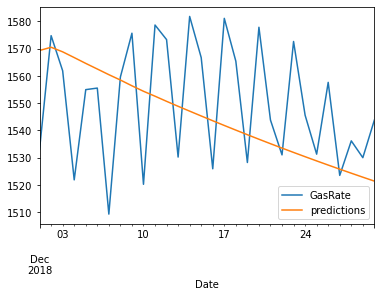

In [33]:
test_data.plot()

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test_data['GasRate'],test_data['predictions']))
print(rmse)

24.97015240749598


# Forecast new data

In [35]:
full_scaler = MinMaxScaler()
data_scaled = full_scaler.fit_transform(df) # scale the whole dataset

In [36]:
length = 12 # Length of the output sequences 
n_features =  1
generator = TimeseriesGenerator(data_scaled, data_scaled, length=length, batch_size=1)

In [37]:
model = Sequential()
model.add(LSTM(200, activation='tanh', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
1208/1208 [==============================] - 5s 4ms/step - loss: 0.0055
Epoch 2/8
1208/1208 [==============================] - 4s 4ms/step - loss: 0.0032
Epoch 3/8
1208/1208 [==============================] - 5s 4ms/step - loss: 0.0029
Epoch 4/8
1208/1208 [==============================] - 5s 4ms/step - loss: 0.0026
Epoch 5/8
1208/1208 [==============================] - 4s 4ms/step - loss: 0.0025
Epoch 6/8
1208/1208 [==============================] - 4s 4ms/step - loss: 0.0024
Epoch 7/8
1208/1208 [==============================] - 4s 4ms/step - loss: 0.0023
Epoch 8/8
1208/1208 [==============================] - 4s 4ms/step - loss: 0.0023


In [38]:
# create for loop to predict the values of each of the following 12 months 
forecast = []
periods = 12

first_eval_batch = data_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [39]:
forecast = scaler.inverse_transform(forecast) # inverse the scaled data

In [40]:
index = pd.date_range(start='2019-01-01',periods=periods,freq='MS') # create a time stamp for the new predictions
forecast_df = pd.DataFrame(data=forecast,index=index,columns=['Forecast'])# create a dataframe of the predictions

<AxesSubplot:xlabel='Date'>

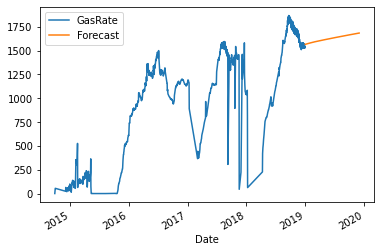

In [41]:
# plot the predictions and the original dataset
ax = df.plot()
forecast_df.plot(ax=ax)

In [42]:
forecast_df

,Forecast
2019-01-01,1565.703806
2019-02-01,1580.446058
2019-03-01,1592.276378
2019-04-01,1603.431322
2019-05-01,1614.233770
2019-06-01,1624.727813
2019-07-01,1635.034696
2019-08-01,1645.174461
2019-09-01,1655.106359
2019-10-01,1664.898750


In [43]:
forecast_df.to_csv('forecast.csv')

In [44]:
model.save("univariate_predictions.h5")

In [45]:
from tensorflow.keras.models import load_model
uni_model = load_model("univariate_predictions.h5")

In [46]:
# create for loop to predict the values of each of the following 12 months 
forecast1 = []
periods2 = 3

first_eval_batch = data_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods2):
    
    # get prediction 1 time stamp ahead 
    current_pred = uni_model.predict(current_batch)[0]
    
    # store prediction
    forecast1.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [47]:
forecast1 = scaler.inverse_transform(forecast1) # inverse the scaled data

In [48]:
index = pd.date_range(start='2019-01-01',periods=periods2,freq='MS') # create a time stamp for the new predictions
forecast_df1 = pd.DataFrame(data=forecast1,index=index,columns=['Forecast'])# create a dataframe of the predictions

<AxesSubplot:xlabel='Date'>

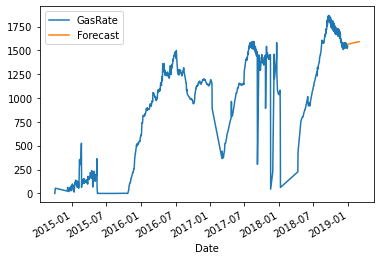

In [49]:
# plot the predictions and the original dataset
ax = df.plot()
forecast_df1.plot(ax=ax)

In [50]:
forecast_df1

,Forecast
2019-01-01,1565.703806
2019-02-01,1580.446058
2019-03-01,1592.276378
